In [1]:
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from model import Forecaster, plot_forecast
from configs import PatchFMConfig
from dataset import UTSDataset

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Instantiate model ---
config = PatchFMConfig(compile=True, load_from_hub=True)
model = Forecaster(config)

Loading base model from HuggingFace Hub...


# Forecasting

In [4]:
# --- Load an artificial dataset ---
#dataset = torch.load("../data/full.pt") # approx 40sec to load
dataset = UTSDataset(input_len=1024, output_len=2*model.patch_len, flag="val")

Indexing dataset...


100%|██████████| 68679/68679 [00:27<00:00, 2498.78it/s]


Context shape: torch.Size([1, 1024]), Target shape: torch.Size([64])


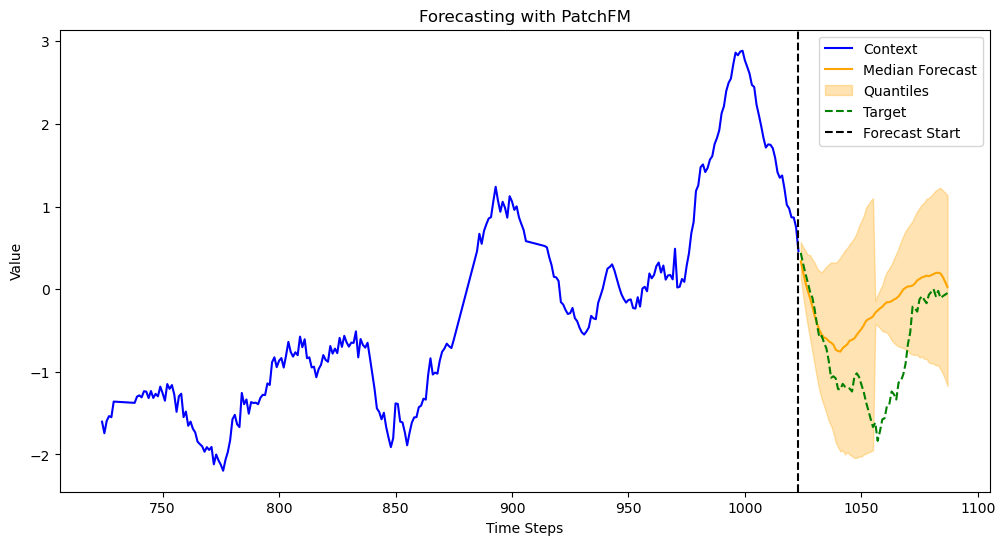

In [46]:
idx = random.randint(0, len(dataset))
context, target = dataset[idx]
xx = torch.cat([context, target], dim=0)

context_size = 1024
forecast_horizon = 64
context_plot_limit = 300

context = xx[:context_size].unsqueeze(0)
target = xx[context_size:forecast_horizon + context_size]

print(f"Context shape: {context.shape}, Target shape: {target.shape}")

pred_median, pred_quantiles = model(context, forecast_horizon=forecast_horizon, quantiles=[0.1, 0.5, 0.9])

plot_forecast(context, pred_median, pred_quantiles, target_pred=target, context_plot_limit=context_plot_limit)